<a href="https://colab.research.google.com/github/Naomiweinberger/Hate-Speech/blob/main/Synthesizes_dataipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook #3-Data Preprocessing using NLTK and Modeling**

**WARNING-DUE TO THE NATURE OF THIS PROJECT,THIS NOTEBOOK CONTAINS WORDS THAT ARE HATEFUL. THIS IS NO WAY REFLECTS THE VIEWS OF THE AUTHOR**

**Import libraries**
I imported the libraries necessary for the modeling process including re,NLTK, and models from sklearn and imblearn.

In [72]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopword=set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, FreqDist
stemmer = nltk.SnowballStemmer("english")
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk import ngrams, FreqDist
nltk.download('punkt')
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix,precision_score, recall_score, accuracy_score, f1_score,roc_curve, auc
from xgboost import XGBClassifier as xbg 
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")
import preprocessor as p
from collections import Counter
import pickle 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weinb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\weinb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\weinb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Model Function** 
I created a function to streamline the modeling process. 

In [73]:
def run_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)    
    cnf_matrix_test = confusion_matrix(y_test,  y_pred_test)
    cnf_matrix_train = confusion_matrix(y_train,  y_pred_train)
    print('Confusion Matrix for Train Set:\n', cnf_matrix_train) 
    print('Confusion Matrix for Test Set:\n', cnf_matrix_test)
 
    cnf_matrix_train = confusion_matrix(y_train,  y_pred_train)
  
    print('Classification Report for Train Set:\n',classification_report(y_train, y_pred_train))
    print('Classification Report for Test Set:\n',classification_report(y_test , y_pred_test))
 
    
    plot_confusion_matrix(model, X_test, y_test,
                     cmap=plt.cm.Blues)
    plot_confusion_matrix(model, X_train, y_train,
                     cmap=plt.cm.Blues)
    
   
    return model

**EDA Data** To see more of the EDA, look at the  [ EDA notebook]('http://localhost:8889/notebooks/Notebooks/Notebook_1_EDA.ipynb')

In [74]:
hatespeech_df = pd.read_csv('C:\\Users\\weinb\\Hate-speech\\Data\\labeleddata.csv')
hatespeech_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [75]:
hatespeech_df2=pd.read_csv('C:\\Users\\weinb\\Hate-speech\\Data\\train_E6oV3lV.csv')
hatespeech_df2.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [76]:
hatespeech_df_1=hatespeech_df[['class','tweet']]

In [77]:
hatespeech_df2['class']=hatespeech_df2['label']

In [78]:
hatespeech_df2['class'] = hatespeech_df2['class'].replace(['0'],'2')

In [79]:
df_2 = pd.DataFrame(hatespeech_df2, columns= ['class','tweet'])
df_2['class'] = df_2['class'].replace([1,0],[0,2])

In [80]:
hatespeech=pd.concat([hatespeech_df_1, df_2])

In [81]:
X=hatespeech['tweet']
y=hatespeech['class']

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)

**Cleaning,Tokenizing,Lemmatizing and Vectorizing the tweets**

I created a function to clean the tweet texts. I then created a class to lemmatize and tokenize the tweet text.I then vectorized the tweet text to fit it through the models. 

In [83]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub("@[A-Za-z0-9_]+", " ", text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\w\s]', '', (text))
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

In [84]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

tf_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),
                       strip_accents = 'unicode',
                       stop_words = 'english',
                       lowercase = True,
                       token_pattern = r'\b[a-zA-Z]{3,}\b', # keeps words of 3 or more characters
                       max_df = 0.5,
                       min_df = 10)

In [85]:
X_train=X_train.apply(clean_text)
X_train.head()

12726    man im tryin take intox charli sheen level tod...
21827          nicca sangin dey partna witout grammi award
17082    rt   bitch ass nigga claim yo homi get dirt  b...
6460                   lmao ur dad rais u bitch made nigga
8482     prayfororlando ðinstagram ð   toptag  toptag n...
Name: tweet, dtype: object

In [86]:
X_test=X_test.apply(clean_text)
X_test.head()

14372            day   season  premier cant wait   thefost
6207                                pick sc take us nip cr
5090                                  go jerk lolli faggot
12005    dream fm inshot girl cute summer blur sun   fu...
4072       fuckin mom bitch like aint even payin dylan ...
Name: tweet, dtype: object

In [87]:
X_train_vec = tf_vectorizer.fit_transform(X_train)
X_test_vec = tf_vectorizer.transform(X_test)

In [88]:
X_train=X_train_vec.todense()
X_test=X_test_vec.todense()

**BASELINE MODELS**

Confusion Matrix for Train Set:
 [[ 2937     1     0]
 [10862  4324   166]
 [11875  3864 11367]]
Confusion Matrix for Test Set:
 [[ 618   72   44]
 [2776  963   99]
 [3100  966 2711]]
Classification Report for Train Set:
               precision    recall  f1-score   support

           0       0.11      1.00      0.21      2938
           1       0.53      0.28      0.37     15352
           2       0.99      0.42      0.59     27106

    accuracy                           0.41     45396
   macro avg       0.54      0.57      0.39     45396
weighted avg       0.77      0.41      0.49     45396

Classification Report for Test Set:
               precision    recall  f1-score   support

           0       0.10      0.84      0.17       734
           1       0.48      0.25      0.33      3838
           2       0.95      0.40      0.56      6777

    accuracy                           0.38     11349
   macro avg       0.51      0.50      0.35     11349
weighted avg       0.74      0.38 

GaussianNB()

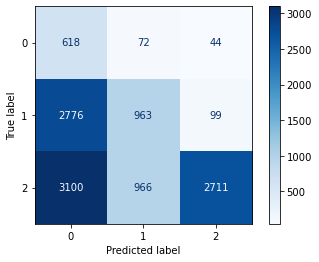

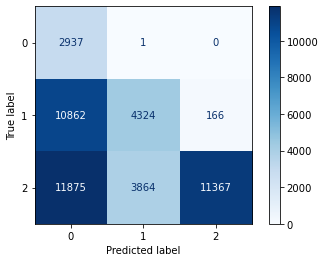

In [18]:
classifier_nb = GaussianNB()
run_model(classifier_nb, X_train, X_test, y_train, y_test)


Confusion Matrix for Train Set:
 [[ 2889    28    21]
 [   35 15284    33]
 [   20    39 27047]]
Confusion Matrix for Test Set:
 [[ 367  177  190]
 [ 141 3486  211]
 [ 388  260 6129]]
Classification Report for Train Set:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2938
           1       1.00      1.00      1.00     15352
           2       1.00      1.00      1.00     27106

    accuracy                           1.00     45396
   macro avg       0.99      0.99      0.99     45396
weighted avg       1.00      1.00      1.00     45396

Classification Report for Test Set:
               precision    recall  f1-score   support

           0       0.41      0.50      0.45       734
           1       0.89      0.91      0.90      3838
           2       0.94      0.90      0.92      6777

    accuracy                           0.88     11349
   macro avg       0.75      0.77      0.76     11349
weighted avg       0.89      0.88 

DecisionTreeClassifier()

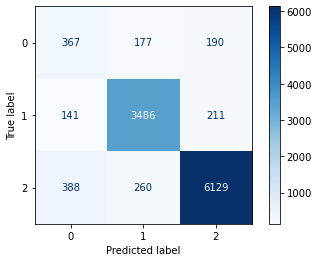

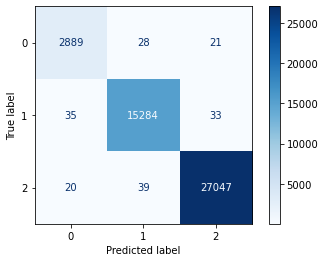

In [19]:
classifier_dt = DecisionTreeClassifier()
run_model(classifier_dt, X_train, X_test, y_train, y_test)

Confusion Matrix for Train Set:
 [[ 1107   567  1264]
 [  330 13922  1100]
 [   96   470 26540]]
Confusion Matrix for Test Set:
 [[ 189  165  380]
 [  88 3361  389]
 [  53  170 6554]]
Classification Report for Train Set:
               precision    recall  f1-score   support

           0       0.72      0.38      0.50      2938
           1       0.93      0.91      0.92     15352
           2       0.92      0.98      0.95     27106

    accuracy                           0.92     45396
   macro avg       0.86      0.75      0.79     45396
weighted avg       0.91      0.92      0.91     45396

Classification Report for Test Set:
               precision    recall  f1-score   support

           0       0.57      0.26      0.36       734
           1       0.91      0.88      0.89      3838
           2       0.89      0.97      0.93      6777

    accuracy                           0.89     11349
   macro avg       0.79      0.70      0.73     11349
weighted avg       0.88      0.89 

KNeighborsClassifier()

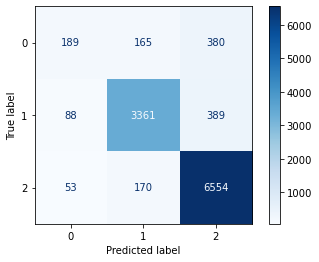

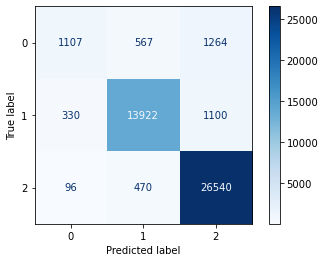

In [18]:
classifier_knn = KNeighborsClassifier()
run_model(classifier_knn, X_train, X_test, y_train, y_test)

Confusion Matrix for Train Set:
 [[ 2862    38    38]
 [   23 15285    44]
 [    4    30 27072]]
Confusion Matrix for Test Set:
 [[ 320  195  219]
 [  65 3567  206]
 [ 115  183 6479]]
Classification Report for Train Set:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      2938
           1       1.00      1.00      1.00     15352
           2       1.00      1.00      1.00     27106

    accuracy                           1.00     45396
   macro avg       0.99      0.99      0.99     45396
weighted avg       1.00      1.00      1.00     45396

Classification Report for Test Set:
               precision    recall  f1-score   support

           0       0.64      0.44      0.52       734
           1       0.90      0.93      0.92      3838
           2       0.94      0.96      0.95      6777

    accuracy                           0.91     11349
   macro avg       0.83      0.77      0.79     11349
weighted avg       0.91      0.91 

RandomForestClassifier()

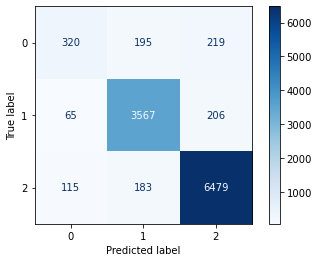

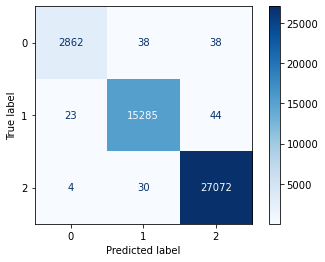

In [19]:
classifier_rf = RandomForestClassifier()
run_model(classifier_rf, X_train, X_test, y_train, y_test)

Confusion Matrix for Train Set:
 [[ 1636   528   774]
 [  219 14441   692]
 [  120   280 26706]]
Confusion Matrix for Test Set:
 [[ 302  157  275]
 [ 100 3487  251]
 [  76   89 6612]]
Classification Report for Train Set:
               precision    recall  f1-score   support

           0       0.83      0.56      0.67      2938
           1       0.95      0.94      0.94     15352
           2       0.95      0.99      0.97     27106

    accuracy                           0.94     45396
   macro avg       0.91      0.83      0.86     45396
weighted avg       0.94      0.94      0.94     45396

Classification Report for Test Set:
               precision    recall  f1-score   support

           0       0.63      0.41      0.50       734
           1       0.93      0.91      0.92      3838
           2       0.93      0.98      0.95      6777

    accuracy                           0.92     11349
   macro avg       0.83      0.77      0.79     11349
weighted avg       0.91      0.92 

LogisticRegression()

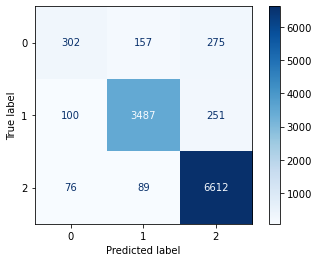

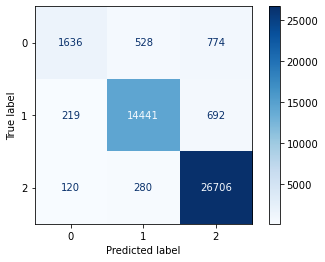

In [20]:
classifier_lr=LogisticRegression()
run_model(classifier_lr,X_train, X_test, y_train, y_test)

[07:00:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Train Set:
 [[ 1194   546  1198]
 [  306 14106   940]
 [   70   195 26841]]
Confusion Matrix for Test Set:
 [[ 238  159  337]
 [  91 3476  271]
 [  45   45 6687]]
Classification Report for Train Set:
               precision    recall  f1-score   support

           0       0.76      0.41      0.53      2938
           1       0.95      0.92      0.93     15352
           2       0.93      0.99      0.96     27106

    accuracy                           0.93     45396
   macro avg       0.88      0.77      0.81     45396
weighted avg       0.92      0.93      0.92     45396

Classification Report for Test Set:
               precision    recall  f1-score   support

           0       0.64      0.32      0.43       73

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

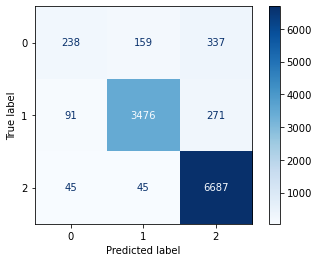

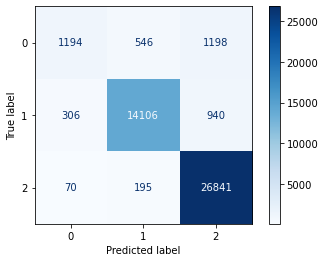

In [21]:
classifier_xg = xbg()
run_model(classifier_xg,X_train, X_test, y_train, y_test)

**Pickle model** I pickled the  best preforming model (The XG Boost) to test it on the validation set. It had a 92% accuracy on the testing set.

In [4]:
import pickle
# Save
with open('xgboost.pickle', 'wb') as f:
    pickle.dump(classifier_xg, f)
   

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\weinb\\Hate-speech\\Pickled Models \\xgboost.pickle'

**Validation set** I scraped twitter to create a new data set using words that were found to be important in each of the classes. See [Notebook 2](http://localhost:8889/notebooks/Notebooks/Notebook_2_Scraping_Twitter.ipynb) for more information. 


In [89]:
# Load
with open( 'C:\\Users\\weinb\\Hate-speech\\Pickled Models\\xgboost.pickle', 'rb') as file:
    model_2 = pickle.load(file)

In [90]:
twitter_new=pd.read_csv('C:\\Users\\weinb\\Hate-speech\\Data\\twitter_3.csv')
twitter_new=twitter_new[['tweet','label']]


In [91]:
validationset_X=twitter_new['tweet']
validationset_y=twitter_new['label']

In [92]:
Clean_X=validationset_X.apply(clean_text)


In [93]:
X_test_vec = tf_vectorizer.transform(Clean_X)

In [94]:
vectorized_X=X_test_vec.todense()

In [98]:
predict_y=model_2.predict(vectorized_X)

In [99]:
twitter_new['prediction']=predict_y

Confusion Matrix for validation Set:
 [[ 11   9  16]
 [  0  78   6]
 [  0   0 100]]
Classification Report for validation Set:
               precision    recall  f1-score   support

           0       1.00      0.31      0.47        36
           1       0.90      0.93      0.91        84
           2       0.82      1.00      0.90       100

    accuracy                           0.86       220
   macro avg       0.91      0.74      0.76       220
weighted avg       0.88      0.86      0.83       220



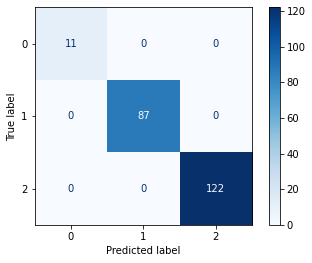

In [103]:
cnf_matrix_validation = confusion_matrix(validationset_y,  predict_y)

print('Confusion Matrix for validation Set:\n', cnf_matrix_validation) 

print('Classification Report for validation Set:\n',classification_report(validationset_y , predict_y))
plot_confusion_matrix(model_2, vectorized_X, predict_y,
                     cmap=plt.cm.Blues)

The best performing model (the XG BOOST) had an accuracy of 86% in predicting what class the tweet from the validation set would be classified to. 